In [1]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio
from slc.data import compute_target
from slc.features import genera2target, load_raster


def _genera2target_raster(path: Path, new_path: Path) -> None:
    target = load_raster(path, monochrome_as_dataframe=True)
    target = genera2target(target)
    target = target.map({"deciduous": 0, "evergreen": 1})
    target = target.to_numpy()

    # Read profile and raster params
    with rasterio.open(path) as src:
        profile = src.profile
        nan_mask = np.isnan(src.read()).all(axis=0)
        nan_mask = np.expand_dims(nan_mask, axis=0)

    shape = nan_mask.shape
    profile["count"] = shape[0]

    # Write prediction to target raster
    shutil.copy(path, new_path)
    with rasterio.open(new_path, "w", **profile) as dst:
        reshaped = target.reshape(shape).astype(float)
        dst.write(reshaped)
        dst.descriptions = ("Evergreen",)


target_path = Path("../data/processed/generalization/traunstein_target.tif")
binary_path = target_path.parent / "traunstein_binary.tif"
target_path.parent.mkdir(parents=True, exist_ok=True)

if not target_path.exists():
    plot = pd.read_csv("../data/interim/test/traunstein.csv")

    compute_target(target_path, plot)
    _genera2target_raster(target_path, new_path=binary_path)

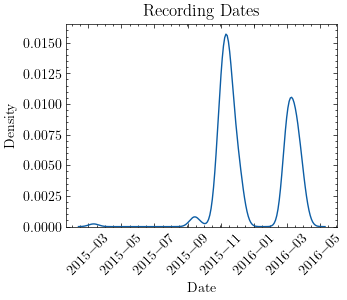

In [2]:
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
import seaborn as sns

plt.style.use("science")

# Plot all recording dates
ax = sns.kdeplot(
    pd.read_csv("../data/interim/test/traunstein.csv")["date"].astype("datetime64[ns]")
)
ax.set_title("Recording Dates")
ax.set_xlabel("Date")
ax.set_ylabel("Density")
plt.xticks(rotation=45)

plt.show()

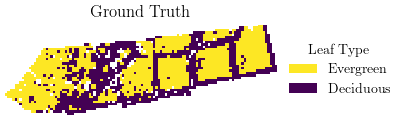

<Figure size 350x262.5 with 0 Axes>

In [3]:
# Plot ground truth
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.patches import Patch

# Prepare the colormap
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create subplot and colorbar
fig, ax = plt.subplots()

# Load the target raster
with rasterio.open(binary_path) as src:
    target_raster = src.read()

# Plot the target raster
ax.imshow(
    target_raster.transpose(1, 2, 0),
    interpolation="nearest",
    cmap=cmap,
    norm=norm,
)
ax.axis("off")
ax.set_title("Ground Truth")

ax.legend(
    handles=[
        Patch(facecolor=viridis.get_over(), label="Evergreen"),
        Patch(facecolor=viridis.get_under(), label="Deciduous"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.show()

Path("../reports/figures/generalization").mkdir(parents=True, exist_ok=True)
figure_path = f"../reports/figures/generalization/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300, transparent=True)

In [4]:
# Compute data
from slc.models import create_data

data_folder = Path("../data/processed/generalization/traunstein_data/")
year = 2018
data_folder.mkdir(parents=True, exist_ok=True)

data_path = data_folder / f"{year}/data.tif"

if not data_path.exists():
    create_data(
        year=year,
        target_path=target_path,
        data_folder=data_folder,
        top_n=10,
    )

In [5]:
import dill

tuning_df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
model_paths = [Path(f"../models/{model}.pkl") for model in tuning_df.index]

tuned_models = []
for model_path in model_paths:
    with model_path.open("rb") as file:
        model = dill.load(file)  # noqa: S301
        tuned_models.append(model)

  0%|          | 0/8 [00:00<?, ?it/s]

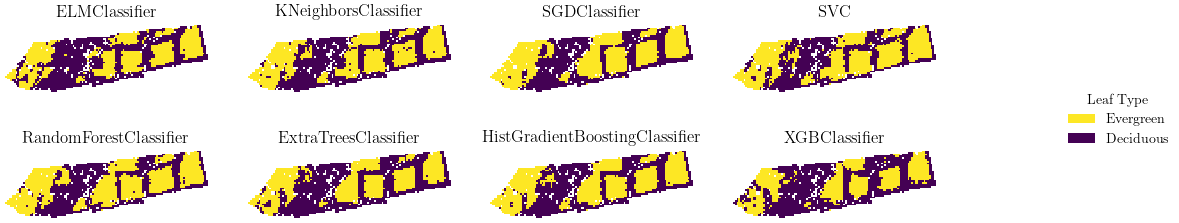

In [6]:
from tqdm.notebook import tqdm

model_folder = Path("../data/processed/generalization/")
model_folder.mkdir(parents=True, exist_ok=True)
fig, axs = plt.subplots(2, 4, figsize=(12, 3))

prediction_rasters = []
for ax, model in tqdm(list(zip(axs.flatten(), tuned_models, strict=False))):
    path = model_folder / f"{model.steps[-1][1].__class__.__name__}.tif"
    if Path(path).exists():
        with rasterio.open(path) as src:
            prediction_raster = src.read()
    else:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        data = load_raster(data_path, monochrome_as_dataframe=True)
        prediction_raster = model.predict(data)
        with rasterio.open(binary_path) as src:
            profile = src.profile
            shape = src.read().shape
            nan_or_larix = np.isnan(src.read())

        prediction_raster = prediction_raster.reshape(shape).astype(float)
        prediction_raster[nan_or_larix] = np.nan

        with rasterio.open(path, "w", **profile) as dst:
            dst.write(prediction_raster)

    prediction_rasters.append(prediction_raster)

    im = ax.imshow(
        prediction_raster.transpose(1, 2, 0),
        interpolation="nearest",
        cmap=cmap,
        norm=norm,
    )
    ax.axis("off")
    ax.set_title(model.steps[-1][1].__class__.__name__)

fig.legend(
    handles=[
        Patch(facecolor=viridis.get_over(), label="Evergreen"),
        Patch(facecolor=viridis.get_under(), label="Deciduous"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

figure_path = "../reports/figures/hyperparameter_tuning/Predictions.svg"
plt.savefig(figure_path, dpi=300, transparent=True)

In [7]:
from collections.abc import Callable

import numpy as np
from sklearn.metrics import f1_score


def _rolling_window(
    x: pd.Series,
    data: pd.DataFrame,
    window_width: float,
    function: Callable,
    n_samples: int = 100,
) -> pd.DataFrame:
    min_sample_size = 2
    if n_samples < min_sample_size:
        msg = "n_samples must be at least 2"
        raise ValueError(msg)

    x = x.reset_index(drop=True)
    data = data.reset_index(drop=True)

    idcs = x.argsort()
    sorted_x = x[idcs]
    data = data.loc[idcs]

    x_values = []
    results = []
    for x_value in np.linspace(sorted_x.min(), sorted_x.max(), n_samples):
        mask = sorted_x.between(x_value - window_width / 2, x_value + window_width / 2)
        data_window = data[mask]
        result = function(data_window)
        x_values.append(x_value)
        results.append(result)

    return pd.DataFrame(results, index=x_values)


def _f1_stats(data: pd.DataFrame) -> dict:
    target = data["Target"].to_numpy()
    prediction = data["Prediction"].to_numpy()

    point_estimate = f1_score(target, prediction)

    n_resamples = 1000
    alpha = 0.95
    index = np.arange(target.size)
    resamples = np.random.default_rng().choice(
        index, size=(n_resamples, index.size), replace=True
    )

    # Vectorized computation of resampled F1 scores
    resampled_f1s = np.array(
        [f1_score(target[resample], prediction[resample]) for resample in resamples]
    )

    lower_bound, upper_bound = np.percentile(
        resampled_f1s, [(1 - alpha) / 2 * 100, (1 + alpha) / 2 * 100]
    )

    return {
        "Point Estimate": point_estimate,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
    }


best_idx = tuning_df["F1 Score"].argmax()
# best_idx = 5  # TODO: remove, as it is only meant for debugging
best_model = tuned_models[best_idx].steps[-1][1].__class__.__name__

dem = load_raster("../data/external/dem_median.tif")
target = load_raster("../data/processed/generalization/traunstein_binary.tif")
prediction = load_raster(f"../data/processed/generalization/{best_model}.tif")

data = pd.DataFrame({"Target": target, "Prediction": prediction})

mask = target.notna()
dem = dem[mask]
data = data[mask]

result_path = Path("../reports/rolling_window.csv")
if not result_path.exists():
    result = _rolling_window(
        dem, data, window_width=5, function=_f1_stats, n_samples=200
    )
    result.to_csv(result_path)
else:
    result = pd.read_csv(result_path, index_col=0)

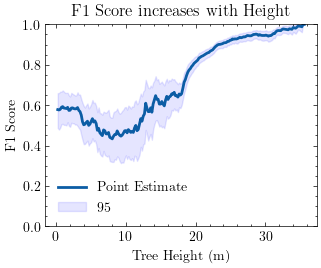

In [8]:
x = result.index
point_estimate = result["Point Estimate"]  # .rolling(window=10).mean()
lower_bound = result["Lower Bound"]  # .rolling(window=10).mean()
upper_bound = result["Upper Bound"]  # .rolling(window=10).mean()

ax = plt.subplot()
ax.plot(x, point_estimate, linewidth=2)
ax.fill_between(x, lower_bound, upper_bound, color="b", alpha=0.1)
ax.set_ylim(0, 1)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score increases with Height")
ax.legend(["Point Estimate", "95% Confidence Interval"])

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300, transparent=True)

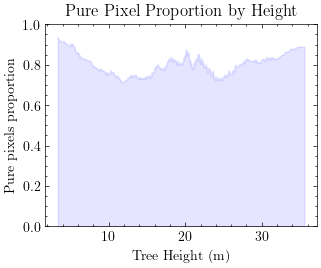

In [9]:
# Plot the percentage of endmembers across the height of the trees
from slc.features import load_raster

window_size = 200

target = load_raster("../data/processed/generalization/traunstein_target.tif")
regression_target = genera2target(target, regression=True).copy()
regression_target["evergreen proportion"] = regression_target[
    "evergreen"
] / regression_target.sum(axis=1)

dem = load_raster("../data/external/dem_median.tif")

target_df = regression_target[
    "evergreen proportion"
].copy()  # pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = target_df.notna()
target_df, prediction_df, dem_df = target_df[mask], prediction_df[mask], dem_df[mask]

# TODO@peter: Note somewhere that endmember if +- 5% of 0 or 1
em_margin = 0.05
endmembers = ((target_df > em_margin) & (target_df < 1 - em_margin)).astype(int)

dem_df = dem_df.reset_index(drop=True)
endmembers = endmembers.reset_index(drop=True)
indices = dem_df.argsort()
endmembers, dem_df = endmembers[indices], dem_df[indices]
moving_average = endmembers.rolling(window_size).mean()

ax = plt.subplot()
ax.fill_between(dem_df, 0, 1 - moving_average, color="b", alpha=0.1)
ax.set_ylim(0, 1)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("Pure pixels proportion")
ax.set_title("Pure Pixel Proportion by Height")

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300, transparent=True)

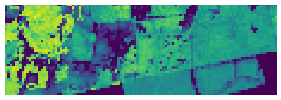

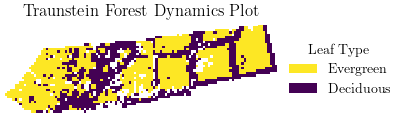

In [10]:
# Predict on new data with the best model
from typing import IO

import numpy as np
import rasterio
from matplotlib.cm import viridis
from matplotlib.patches import Patch
from rasterio.plot import show


def _plot_src(
    src: IO,
    title: str | None = None,
    contains_larix: pd.Series | None = None,
    *,
    alternative_dlt: bool = False,
) -> None:
    if contains_larix is not None:
        src = src.read()
        larix_raster = contains_larix.to_numpy().reshape(src.shape[1:])
        src[:, larix_raster] = np.nan

    ax = plt.subplot()
    ax = show(src, interpolation="nearest", ax=ax)
    ax.axis("off")

    if title:
        ax.set_title(title)

    handles = [
        Patch(facecolor=viridis.get_over(), label="Conifer"),
        Patch(facecolor=viridis.get_under(), label="Broadleaf"),
    ]
    if alternative_dlt:
        handles = [
            Patch(facecolor=viridis.get_over(), label="Evergreen"),
            Patch(facecolor=viridis.get_under(), label="Deciduous"),
        ]

    ax.legend(
        handles=handles,
        title="Leaf Type",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )

    plt.show()


dem_path = Path("../data/external/dem_median.tif")
with rasterio.open(dem_path) as src:
    ax = plt.subplot()
    show(src, interpolation="nearest", ax=ax)
    ax.axis("off")

    plt.show()

contains_larix = load_raster(target_path)["Larix"] > 0
with rasterio.open(binary_path) as src:
    _plot_src(
        src,
        title="Traunstein Forest Dynamics Plot",
        alternative_dlt=True,
        contains_larix=contains_larix,
    )

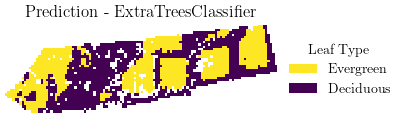

In [11]:
best_model = tuned_models[best_idx].steps[-1][1].__class__.__name__
prediction_path = model_folder / f"{best_model}.tif"
with rasterio.open(prediction_path) as src:
    _plot_src(
        src,
        title=f"Prediction - {best_model}",
        alternative_dlt=True,
        contains_larix=contains_larix,
    )

    nan_or_larix = np.isnan(src.read())

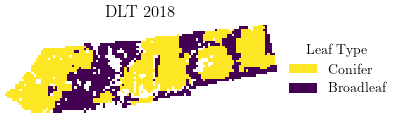

In [12]:
from slc.data import download_dlt_2018
from slc.features import genera2target

dlt_2018_path = Path("../data/external/dlt_2018.tif")
download_dlt_2018(binary_path, dlt_2018_path, use_mask=True)

with rasterio.open(dlt_2018_path) as src:
    _plot_src(src, title="DLT 2018", contains_larix=contains_larix)

{'accuracy': 0.8061312607944733,
 'f1': np.float64(0.8086701692386237),
 'kappa': np.float64(0.6166620218615495),
 'cm': array([[ 827,   61],
        [ 388, 1040]]),
 'dlt_accuracy': 0.8190846286701209,
 'dlt_f1': np.float64(0.8190264888530134),
 'dlt_kappa': np.float64(0.6171233233432287),
 'dlt_cm': array([[ 677,  211],
        [ 208, 1220]])}

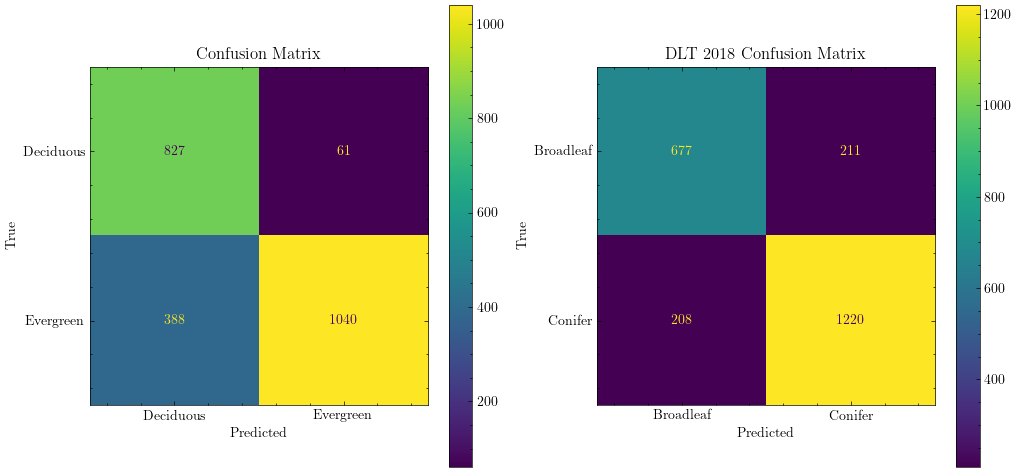

In [13]:
# Compare our approach with DLT 2018 for each metric
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
)


def _compare_with_dlt_2018(
    binary_path: Path, prediction_path: Path, dlt_path: Path, contains_larix: pd.Series
) -> dict:
    # TODO: mask all pixels containing larix
    with rasterio.open(binary_path) as src:
        target = src.read(1)
        shape = target.shape
        contains_larix = contains_larix.to_numpy().reshape(shape)

    with rasterio.open(prediction_path) as src:
        prediction = src.read(1)

    # TODO: evergreen_larix=True to compare it 1:1 with DLT 2018
    with rasterio.open(dlt_path) as src:
        dlt = src.read(1)

    # Mask out NaN values and pixels containing Larix
    nan_or_larix = (
        np.isnan(target) | np.isnan(prediction) | np.isnan(dlt) | contains_larix
    )
    target = target[~nan_or_larix]
    prediction = prediction[~nan_or_larix]
    dlt = dlt[~nan_or_larix]

    # Calculate metrics
    accuracy = accuracy_score(target, prediction)
    f1 = f1_score(target, prediction, average="weighted")
    kappa = cohen_kappa_score(target, prediction)
    cm = confusion_matrix(target, prediction)

    dlt_accuracy = accuracy_score(target, dlt)
    dlt_f1 = f1_score(target, dlt, average="weighted")
    dlt_kappa = cohen_kappa_score(target, dlt)
    dlt_cm = confusion_matrix(target, dlt)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "kappa": kappa,
        "cm": cm,
        "dlt_accuracy": dlt_accuracy,
        "dlt_f1": dlt_f1,
        "dlt_kappa": dlt_kappa,
        "dlt_cm": dlt_cm,
    }


metrics = _compare_with_dlt_2018(
    binary_path, prediction_path, dlt_2018_path, contains_larix
)

cm = metrics["cm"]
dlt_cm = metrics["dlt_cm"]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
display_labels = ["Deciduous", "Evergreen"]
ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(
    ax=axs[0], cmap="viridis"
)
axs[0].set_title("Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

display_labels = ["Broadleaf", "Conifer"]
ConfusionMatrixDisplay(dlt_cm, display_labels=display_labels).plot(
    ax=axs[1], cmap="viridis"
)
axs[1].set_title("DLT 2018 Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

metrics